In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# load data

In [2]:
df_data = pd.read_csv('ozone_eighthr.csv')
df_data.replace(['?'],[-999], inplace =True)
df_data.fillna(-999, inplace =True)
df_data.columns

Index(['Date', 'WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7',
       'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15',
       'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23',
       'WSR_PK', 'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7',
       'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17',
       'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85',
       'U85', 'V85', 'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50',
       'RH50', 'U50', 'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp',
       'Orzone'],
      dtype='object')

In [3]:
label = df_data.pop('Orzone').values
df_data.pop('Date')
data = df_data.values
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=999)

# different models

AUC of lgb is: 0.9427506775067751
AUC of RF is: 0.868309620596206
AUC of tree is: 0.671900406504065


/home/ming/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ming/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ming/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ming/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


AUC of LR is: 0.8161754742547426
AUC of SVM is: 0.5541836043360434


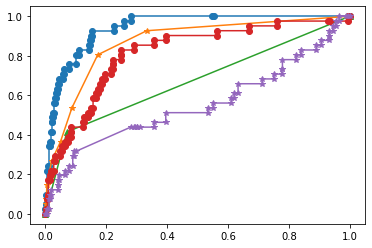

In [4]:
def train(model, model_name):
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    AUC = metrics.roc_auc_score(y_test,y_score)
    print('AUC of %s is: %s' %(model_name,AUC))
    return fpr, tpr
    

model1 = LGBMClassifier(boosting_type='gbdt', objective='binary')
model2 = RandomForestClassifier()
model3 = DecisionTreeClassifier()
model4 = LogisticRegression()  
model5 = SVC(probability=True)

fpr1, tpr1 = train(model1, 'lgb')
fpr2, tpr2 = train(model2, 'RF')
fpr3, tpr3 = train(model3, 'tree')
fpr4, tpr4 = train(model4, 'LR')
fpr5, tpr5 = train(model5, 'SVM')

plt.plot(fpr1, tpr1, marker = 'o')
plt.plot(fpr2, tpr2, marker = '*')
plt.plot(fpr3, tpr3, marker = '^')
plt.plot(fpr4, tpr4, marker = 'o')
plt.plot(fpr5, tpr5, marker = '*')
plt.show()

# defferent parameter

In [5]:
L = []
R = []
auc = []
for depth in [3,4,5,6,7,8]:
    clf = LGBMClassifier(boosting_type='gbdt', 
                             objective='binary',
                             max_depth = depth
                        )  
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)  
    
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[1]	valid_0's auc: 0.843801	valid_0's binary_logloss: 0.200003
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.868327	valid_0's binary_logloss: 0.19135
[3]	valid_0's auc: 0.881301	valid_0's binary_logloss: 0.185544
[4]	valid_0's auc: 0.886738	valid_0's binary_logloss: 0.180508
[5]	valid_0's auc: 0.893106	valid_0's binary_logloss: 0.175454
[6]	valid_0's auc: 0.895969	valid_0's binary_logloss: 0.172265
[7]	valid_0's auc: 0.899543	valid_0's binary_logloss: 0.1688
[8]	valid_0's auc: 0.902507	valid_0's binary_logloss: 0.166655
[9]	valid_0's auc: 0.903066	valid_0's binary_logloss: 0.164585
[10]	valid_0's auc: 0.904895	valid_0's binary_logloss: 0.162587
[11]	valid_0's auc: 0.90957	valid_0's binary_logloss: 0.159967
[12]	valid_0's auc: 0.912432	valid_0's binary_logloss: 0.158047
[13]	valid_0's auc: 0.910349	valid_0's binary_logloss: 0.157337
[14]	valid_0's auc: 0.90918	valid_0's binary_logloss: 0.156887
[15]	valid_0's auc: 0.914736	valid_0's binary_logloss: 0

[7]	valid_0's auc: 0.907622	valid_0's binary_logloss: 0.159662
[8]	valid_0's auc: 0.911822	valid_0's binary_logloss: 0.156347
[9]	valid_0's auc: 0.915176	valid_0's binary_logloss: 0.152634
[10]	valid_0's auc: 0.915075	valid_0's binary_logloss: 0.150923
[11]	valid_0's auc: 0.914228	valid_0's binary_logloss: 0.149839
[12]	valid_0's auc: 0.912907	valid_0's binary_logloss: 0.148694
[13]	valid_0's auc: 0.91582	valid_0's binary_logloss: 0.146148
[14]	valid_0's auc: 0.914668	valid_0's binary_logloss: 0.144796
[15]	valid_0's auc: 0.915617	valid_0's binary_logloss: 0.143699
[16]	valid_0's auc: 0.913381	valid_0's binary_logloss: 0.142898
[17]	valid_0's auc: 0.917852	valid_0's binary_logloss: 0.140804
[18]	valid_0's auc: 0.916023	valid_0's binary_logloss: 0.140935
[19]	valid_0's auc: 0.917852	valid_0's binary_logloss: 0.140117
[20]	valid_0's auc: 0.918259	valid_0's binary_logloss: 0.13894
[21]	valid_0's auc: 0.916396	valid_0's binary_logloss: 0.138915
[22]	valid_0's auc: 0.917175	valid_0's binary

[1]	valid_0's auc: 0.804099	valid_0's binary_logloss: 0.194634
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.846104	valid_0's binary_logloss: 0.186128
[3]	valid_0's auc: 0.874983	valid_0's binary_logloss: 0.178648
[4]	valid_0's auc: 0.887331	valid_0's binary_logloss: 0.172568
[5]	valid_0's auc: 0.905403	valid_0's binary_logloss: 0.16642
[6]	valid_0's auc: 0.913499	valid_0's binary_logloss: 0.160703
[7]	valid_0's auc: 0.920105	valid_0's binary_logloss: 0.156086
[8]	valid_0's auc: 0.921985	valid_0's binary_logloss: 0.152759
[9]	valid_0's auc: 0.921748	valid_0's binary_logloss: 0.150665
[10]	valid_0's auc: 0.926016	valid_0's binary_logloss: 0.147255
[11]	valid_0's auc: 0.929167	valid_0's binary_logloss: 0.144582
[12]	valid_0's auc: 0.931301	valid_0's binary_logloss: 0.141739
[13]	valid_0's auc: 0.931673	valid_0's binary_logloss: 0.140307
[14]	valid_0's auc: 0.934722	valid_0's binary_logloss: 0.137869
[15]	valid_0's auc: 0.933909	valid_0's binary_loglos

[0.9399051490514906, 0.9352642276422765, 0.9290650406504065, 0.9430216802168021, 0.9327574525745257, 0.9362804878048779]


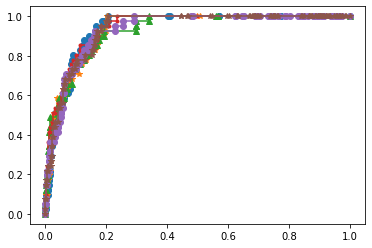

In [6]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.plot(L[5], R[5], marker = '*') 
plt.show()

In [7]:
L = []
R = []
auc = []
for num in [30, 50, 70, 90, 110]:
    clf = LGBMClassifier(boosting_type='gbdt', 
                             objective='binary',
                             num_leaves = num
                        )  
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)  
    
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[1]	valid_0's auc: 0.804099	valid_0's binary_logloss: 0.194634
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.845867	valid_0's binary_logloss: 0.186127
[3]	valid_0's auc: 0.875017	valid_0's binary_logloss: 0.178646
[4]	valid_0's auc: 0.887534	valid_0's binary_logloss: 0.172581
[5]	valid_0's auc: 0.902625	valid_0's binary_logloss: 0.166717
[6]	valid_0's auc: 0.911094	valid_0's binary_logloss: 0.161396
[7]	valid_0's auc: 0.918716	valid_0's binary_logloss: 0.15678
[8]	valid_0's auc: 0.91958	valid_0's binary_logloss: 0.153821
[9]	valid_0's auc: 0.923984	valid_0's binary_logloss: 0.149599
[10]	valid_0's auc: 0.92544	valid_0's binary_logloss: 0.146969
[11]	valid_0's auc: 0.928862	valid_0's binary_logloss: 0.144292
[12]	valid_0's auc: 0.928862	valid_0's binary_logloss: 0.143309
[13]	valid_0's auc: 0.927575	valid_0's binary_logloss: 0.141657
[14]	valid_0's auc: 0.928049	valid_0's binary_logloss: 0.140378
[15]	valid_0's auc: 0.931131	valid_0's binary_logloss:

[17]	valid_0's auc: 0.937195	valid_0's binary_logloss: 0.133044
[18]	valid_0's auc: 0.935705	valid_0's binary_logloss: 0.132836
[19]	valid_0's auc: 0.935061	valid_0's binary_logloss: 0.133178
[20]	valid_0's auc: 0.934146	valid_0's binary_logloss: 0.133377
[21]	valid_0's auc: 0.936009	valid_0's binary_logloss: 0.13194
[22]	valid_0's auc: 0.937263	valid_0's binary_logloss: 0.131243
[23]	valid_0's auc: 0.938516	valid_0's binary_logloss: 0.130599
[24]	valid_0's auc: 0.938415	valid_0's binary_logloss: 0.130301
[25]	valid_0's auc: 0.937568	valid_0's binary_logloss: 0.130502
[26]	valid_0's auc: 0.938482	valid_0's binary_logloss: 0.13036
[27]	valid_0's auc: 0.937127	valid_0's binary_logloss: 0.131195
[28]	valid_0's auc: 0.938618	valid_0's binary_logloss: 0.129734
[29]	valid_0's auc: 0.939228	valid_0's binary_logloss: 0.12918
[30]	valid_0's auc: 0.939634	valid_0's binary_logloss: 0.128901
[31]	valid_0's auc: 0.939465	valid_0's binary_logloss: 0.128569
[32]	valid_0's auc: 0.938991	valid_0's bina

[0.932960704607046, 0.9467140921409214, 0.9467140921409214, 0.9467140921409214, 0.9467140921409214]


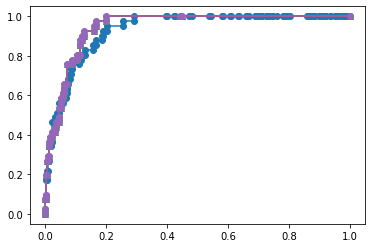

In [8]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.show()

In [9]:
L = []
R = []
auc = []
for num in [500, 600, 700, 800, 900]:
    clf = LGBMClassifier(boosting_type='gbdt', 
                             objective='binary',
                             n_estimators = num
                        )  
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)  
    
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[1]	valid_0's auc: 0.804099	valid_0's binary_logloss: 0.194634
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.846104	valid_0's binary_logloss: 0.186128
[3]	valid_0's auc: 0.874983	valid_0's binary_logloss: 0.178648
[4]	valid_0's auc: 0.8875	valid_0's binary_logloss: 0.172587
[5]	valid_0's auc: 0.902761	valid_0's binary_logloss: 0.166717
[6]	valid_0's auc: 0.911196	valid_0's binary_logloss: 0.161392
[7]	valid_0's auc: 0.918852	valid_0's binary_logloss: 0.156775
[8]	valid_0's auc: 0.919682	valid_0's binary_logloss: 0.153817
[9]	valid_0's auc: 0.923916	valid_0's binary_logloss: 0.149595
[10]	valid_0's auc: 0.92544	valid_0's binary_logloss: 0.146969
[11]	valid_0's auc: 0.928997	valid_0's binary_logloss: 0.144294
[12]	valid_0's auc: 0.928896	valid_0's binary_logloss: 0.143315
[13]	valid_0's auc: 0.927541	valid_0's binary_logloss: 0.141672
[14]	valid_0's auc: 0.927981	valid_0's binary_logloss: 0.140397
[15]	valid_0's auc: 0.931131	valid_0's binary_logloss:

[10]	valid_0's auc: 0.92544	valid_0's binary_logloss: 0.146969
[11]	valid_0's auc: 0.928997	valid_0's binary_logloss: 0.144294
[12]	valid_0's auc: 0.928896	valid_0's binary_logloss: 0.143315
[13]	valid_0's auc: 0.927541	valid_0's binary_logloss: 0.141672
[14]	valid_0's auc: 0.927981	valid_0's binary_logloss: 0.140397
[15]	valid_0's auc: 0.931131	valid_0's binary_logloss: 0.138203
[16]	valid_0's auc: 0.92998	valid_0's binary_logloss: 0.13779
[17]	valid_0's auc: 0.929336	valid_0's binary_logloss: 0.136688
[18]	valid_0's auc: 0.929743	valid_0's binary_logloss: 0.135807
[19]	valid_0's auc: 0.932486	valid_0's binary_logloss: 0.134145
[20]	valid_0's auc: 0.932554	valid_0's binary_logloss: 0.13319
[21]	valid_0's auc: 0.931098	valid_0's binary_logloss: 0.133663
[22]	valid_0's auc: 0.928896	valid_0's binary_logloss: 0.134477
[23]	valid_0's auc: 0.927913	valid_0's binary_logloss: 0.135034
[24]	valid_0's auc: 0.927676	valid_0's binary_logloss: 0.134857
[25]	valid_0's auc: 0.927134	valid_0's binar

[0.9324525745257453, 0.9324525745257453, 0.9324525745257453, 0.9324525745257453, 0.9324525745257453]


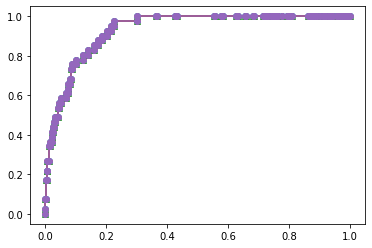

In [10]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.show()

# defferent data split ratio

In [11]:
clf = LGBMClassifier(boosting_type='gbdt', objective='binary')

L = []
R = []
auc = []
for size in [0.3, 0.4,0.5, 0.6, 0.7]:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=size, random_state=999)
    
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)  
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[1]	valid_0's auc: 0.804099	valid_0's binary_logloss: 0.194634
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.846104	valid_0's binary_logloss: 0.186128
[3]	valid_0's auc: 0.874983	valid_0's binary_logloss: 0.178648
[4]	valid_0's auc: 0.8875	valid_0's binary_logloss: 0.172587
[5]	valid_0's auc: 0.902761	valid_0's binary_logloss: 0.166717
[6]	valid_0's auc: 0.911196	valid_0's binary_logloss: 0.161392
[7]	valid_0's auc: 0.918852	valid_0's binary_logloss: 0.156775
[8]	valid_0's auc: 0.919682	valid_0's binary_logloss: 0.153817
[9]	valid_0's auc: 0.923916	valid_0's binary_logloss: 0.149595
[10]	valid_0's auc: 0.92544	valid_0's binary_logloss: 0.146969
[11]	valid_0's auc: 0.928997	valid_0's binary_logloss: 0.144294
[12]	valid_0's auc: 0.928896	valid_0's binary_logloss: 0.143315
[13]	valid_0's auc: 0.927541	valid_0's binary_logloss: 0.141672
[14]	valid_0's auc: 0.927981	valid_0's binary_logloss: 0.140397
[15]	valid_0's auc: 0.931131	valid_0's binary_logloss:

[1]	valid_0's auc: 0.784916	valid_0's binary_logloss: 0.210593
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.834612	valid_0's binary_logloss: 0.202578
[3]	valid_0's auc: 0.852917	valid_0's binary_logloss: 0.196289
[4]	valid_0's auc: 0.86396	valid_0's binary_logloss: 0.190771
[5]	valid_0's auc: 0.871352	valid_0's binary_logloss: 0.186923
[6]	valid_0's auc: 0.875215	valid_0's binary_logloss: 0.183573
[7]	valid_0's auc: 0.881233	valid_0's binary_logloss: 0.180282
[8]	valid_0's auc: 0.87629	valid_0's binary_logloss: 0.179358
[9]	valid_0's auc: 0.878713	valid_0's binary_logloss: 0.177007
[10]	valid_0's auc: 0.876776	valid_0's binary_logloss: 0.175969
[11]	valid_0's auc: 0.878566	valid_0's binary_logloss: 0.174377
[12]	valid_0's auc: 0.880039	valid_0's binary_logloss: 0.172345
[13]	valid_0's auc: 0.879938	valid_0's binary_logloss: 0.170954
[14]	valid_0's auc: 0.877149	valid_0's binary_logloss: 0.171791
[15]	valid_0's auc: 0.87612	valid_0's binary_logloss:

[0.9324525745257453, 0.9220150690205137, 0.9345117527909935, 0.9182490113614964, 0.8811931586806026]


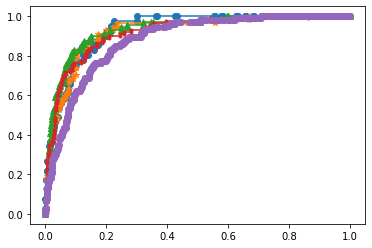

In [12]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.show()